In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

##warning 무시 추가
import warnings
warnings.filterwarnings('ignore')

### 2.1 Load data

In [2]:
# Load data(데이터 불러오기)
##### Load train and Test set

train = pd.read_csv("data/titanic/train.csv") ##891 X 12
test = pd.read_csv("data/titanic/test.csv") ## 418 X 11
IDtest = test["PassengerId"]

### 2.2 Outlier detection //이상치 탐색

In [3]:
# Outlier detection 이상치 탐색

def detect_outliers(df, n, features):
    'df의 feature들을 가져오고, '
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25) ## 1사분위수 구하기
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75) ## 3사분위수 구하기
        # Interquartile range (IQR)
        IQR = Q3 - Q1 #3사분위수 - 1사분위수 = IQR
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col) #이상치들을 리스트에 추가
        
    # select observations containing more than 2 outliers ## 두번이상의 이상치들을 추가
    outlier_indices = Counter(outlier_indices) ## 같은 index가 두번인것들을 찾기 위해 counter 함수 사용
    ## counter 함수 사용으로 dictionary 상태로 나오기 때문에
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    ## k, v (key: value)로 리스트 정리하고, v는 몇번 나왔는지 횟수, v > n 은 n번이상 나온 index를 찾는방법
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])


#이상치 처리 방법
#Minimun = Q1 - 1.5 * IQR , Maximum = Q3 + 1.5 * IQR
#Min , Max 사이 그외의 있는 수는 이상치로 간주한다


In [4]:
train.loc[Outliers_to_drop] # 이상치 row 표출

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set // train test 세트 결합

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
## 범주형 변환 중에 동일한 수의 feature를 얻기 위해 train 및 test dataset 결합
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.4 check for null and missing values // null값과 결측치 검증

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan) ## dataset = train, test에서 결측지

# Check for Null values
print(dataset.isnull().sum()) ## dataset에서 null값

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64


In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

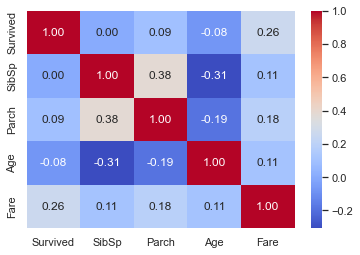

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
#annot = true 셀에 값 표시, fmt = '.2f' 소수2번째 자리까지

##### SibSP 함께 탑승한 형제 또는 배우자수

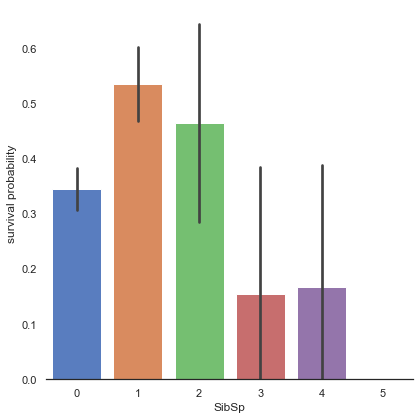

In [13]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

형제/배우자(sibling/spouses)가 많은 승객들이 생존확률이 낮은것 같다.  
1인(0 SibSP), 2인(1, 2 SibSP)가 생존확률 높은것 같다.

##### Parch 가족 수

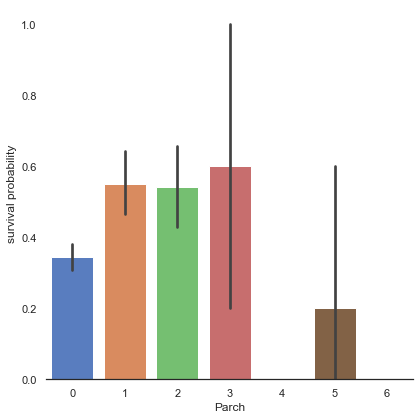

In [14]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children

##### Age 나이

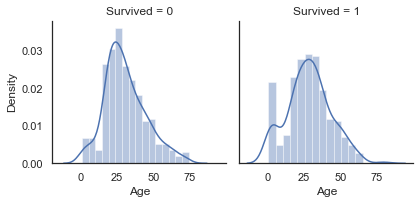

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.  
연령 분포는 꼬리가 있는 분포인것 같다. 아마도 가우스 분포

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.  
우리는 생존한 하위 모집단과 생존하지 않은 하위 모집단에서 연령 분포가 같지 않다는 것을 알아차렸다. 실제로 살아남은 젊은 승객에 상응하는 정점이 있다. 우리는 또한 60-80 사이의 승객들이 덜 살아남았다는 것을 볼 수 있다.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.  
따라서, "살아남은 나이"와 상관관계가 없다고 하더라도, 우리는 생존할 가능성이 다소 있는 승객들의 연령 범주가 있다는 것을 알 수 있다.

It seems that very young passengers have more chance to survive.  
아주 어린 승객들이 살아남을 기회가 더 많은 것 같다.

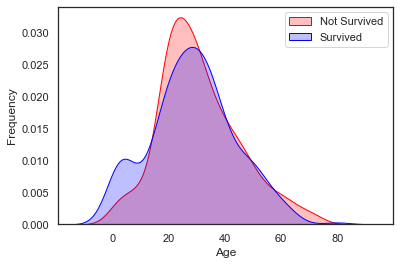

In [16]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.  
우리가 두 밀도를 중첩할 때, 우리는 분명히 아기와 매우 어린 아이들에게 대응하는 피크(0과 5 사이)를 본다.

##### Fare 요금

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
#Fill Fare missing values with the median value
##중간값으로 Fare의 결측치를 채운다
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

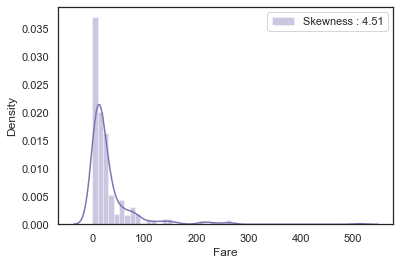

In [19]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best") ##범례 표시

In [20]:
# Apply log to Fare to reduce skewness distribution
## Fare에 로그를 적용한다. 뒤틀림 정도를 줄이기 위해
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

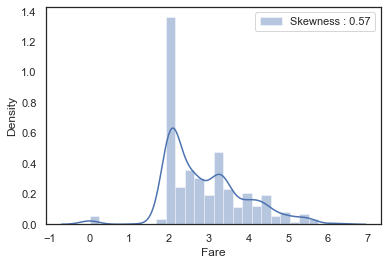

In [21]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

## 로그를 적용한 Fare plot

Skewness is clearly reduced after the log transformation.  
뒤틀림이 명확히 줄었다. 로그변환후에

### 3.2 Categorical values

##### sex 성별

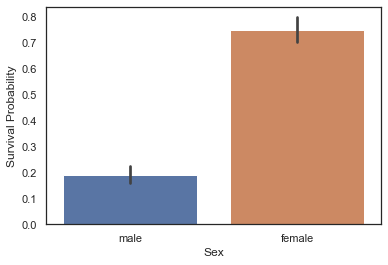

In [22]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [23]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female.  
확실히 남성이 살아남을 확률은 적었다. 여성보다는

So Sex, might play an important role in the prediction of the survival.  
그래서 성별은 생존확률 예측에 중요한 요소로 작용 할 수 있는것 같다

For those who have seen the Titanic movie (1997), I am sure, we all remember this sentence during the evacuation : "Women and children first".  
타이타닉 영화(1997년)를 본 사람들에게, 나는 우리 모두가 대피하는 동안 이 문장을 기억한다고 확신한다: "여성과 아이들이 먼저".

#### Pclass 객실등급

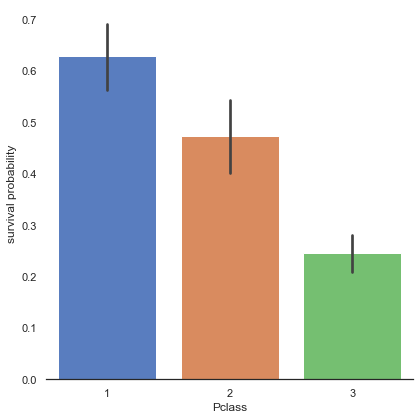

In [24]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True) ## 좌측 축 테두리 제거
g = g.set_ylabels("survival probability")

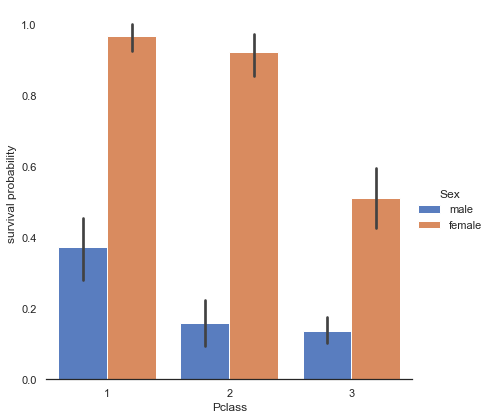

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x='Pclass', y='Survived', hue = 'Sex', data = train, size=6, kind='bar', palette='muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.  
승객 생존확률은 3개의 클래스가 같지 않다. 1등석 승객은 2등석, 3등석 승객보다 생존할 기회가 많았다.

This trend is conserved when we look at both male and female passengers  
이 경향은 남성, 여성 둘다 볼때

##### Embarked 탑승구

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
## Embarked 결측치를 가장 빈도수 높은 'S'로 채운다
dataset["Embarked"] = dataset["Embarked"].fillna("S")

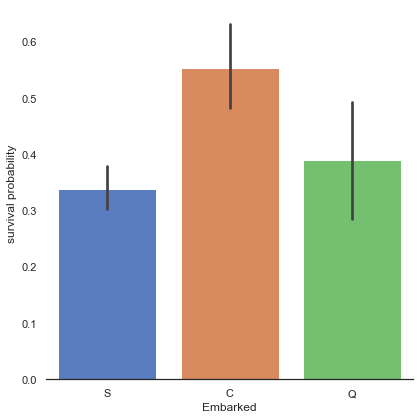

In [28]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive.  
(C) 셰르부르에서 탄 승객들이 살 생존확률이 더 높았다

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).  
내 가설은 퍼스트클래스 승객의 비율이 (Q) 퀸스타운, (S) 사우스햄튼에서 온 승객들 보다 더 높다

Let's see the Pclass distribution vs Embarked  
Pclass 분포와 탑승구 분포를 보자!

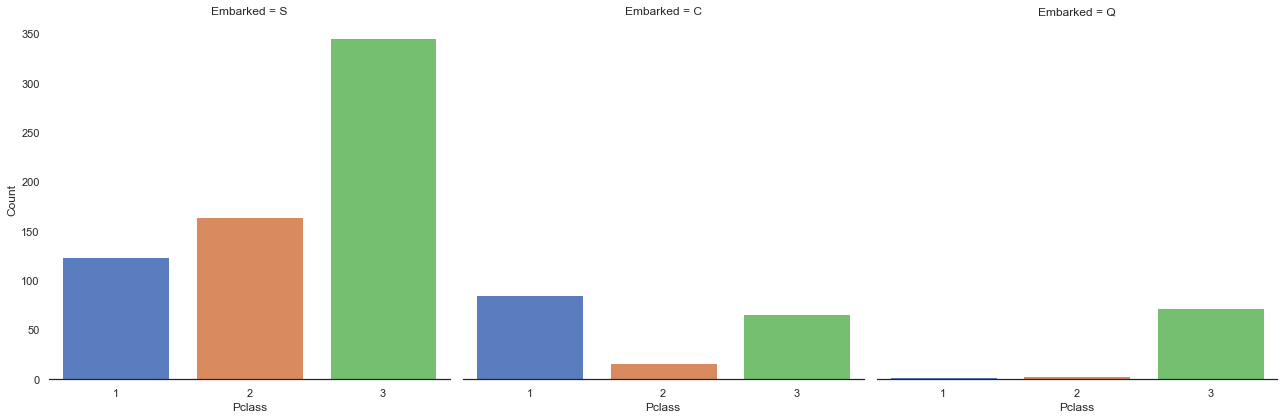

In [29]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.  
실제로, 3등석은 (S)사우스햄튼, (Q)퀸즈타운에서온 승객들이 많은 반면, (C)셰르부르에서 온 승객은 1등석이 가장 높은 생존확률을 나타낸다.

At this point, i can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.  
여기서 포인트는 나는 왜 1등석이 높은 생존확률을 가지고 있는지 설명할수없다. 나의 가설은 1등석 승객이 그들의 영향성?(권력느낌인것같음) 때문에 대피하는동안 높은 우선순위가 매겨졌다. 

## 4. Filling missing Values

### 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.  
우리가 볼때, Age column은 256개의 결측값을 가지고 있다. 전체 데이터에서

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.  
더 높은 생존확률을 가지는 하위집단이 있기 때문에(예를들어 아이들), 연령 특성을 유지하고, 결측값을 전가하는것이 더 좋을것 같다

To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).  
이 문제를 해결하기 위해, 나는 나이(성별, 가족수, 탑승구, 일행수)와 가장 상관관계가 있는 특징을 살펴보았다.

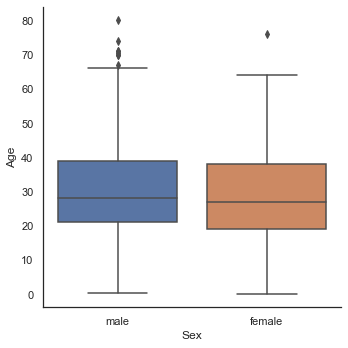

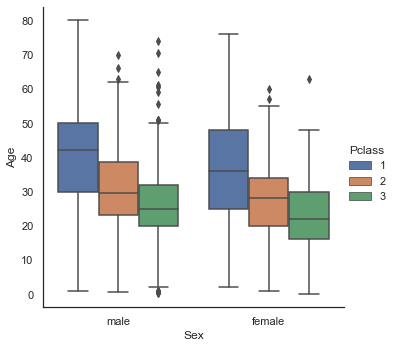

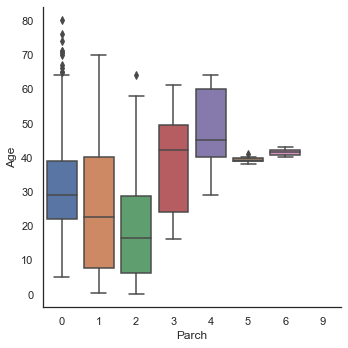

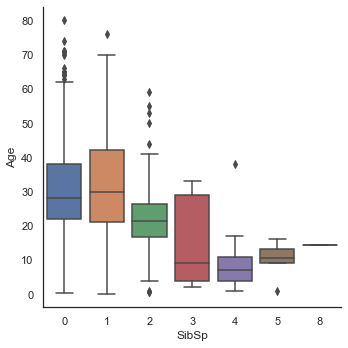

In [30]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.  
나이 분포는 남성과 여성의 하위분포에서 동일한것으로 보여진다. 그래서 성별은 나이를 예측하는데 유용하지 않은것 같다.

However, 1st class passengers are older than 2nd class passengers who are also older than 3rd class passengers.  
하지만, 1등석 승객은 2등석 3등석 승객보다 더 나이 많다.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.  
게다가, 승객들은 부모/아이들(Parch)을 가지고 있을 수록 나이가 많고, 형제/배우자(SibSP)를 가지고 있을수록 젊다

In [31]:
# convert Sex into categorical value 0 for male and 1 for female
## 0을 남성, 1을 여성으로 변환
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

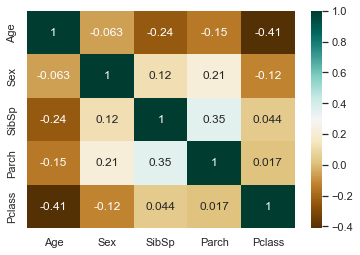

In [32]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.  
- 이 상관관계 맵은 factorplot 관측치를 부모/아이들(Parch) 제외하고 확인한다. 나이는 상관관계가 없다, 그러나 객실등급(Pclass), 부모/아이들(Parch), 형제/배우자(SibSp)와는 음의 상관관계를 가진다

In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.  
- 의역) Age와 Parch는 거의 비례를 나타낸다. 하지만 일반적인 상관관계는 음의 상관관계이다

So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.  
- 그래서 나는 형제/배우자(SibSp), 부모/아이들(Parch), 객실등급(Pclass) 사용을 결심했다. 결측치를 대체하기 위해

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.  
- 이 전략은 객실등급(Pclass), 부모/아이들(Parch), 형제/배우자(SibSp)에 따른 유사한 행의 중위수 나이로 Age를 채우는 것입니다.

In [33]:
# Filling missing value of Age 
## 나이 결측치 채우기

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
## Pclass, Parch, SibSP에 따라 유사한 행의 중위수 나이로 채우기
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & 
                               (dataset['Parch'] == dataset.iloc[i]["Parch"]) & 
                               (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

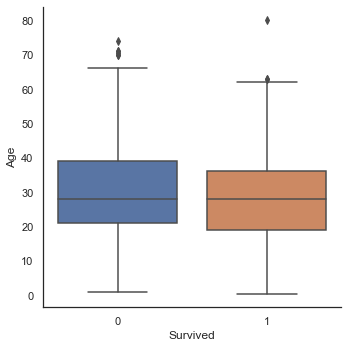

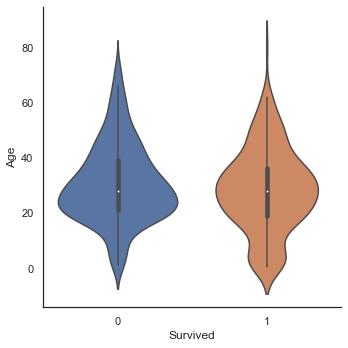

In [34]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

No difference between median value of age in survived and not survived subpopulation.  
- 나이의 중위수의 차이점이 없다 생존했는지와 생존하지못했는지에

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.  
- 하지만 생존 승객의 violin plot에서는 우리는 매우 어린 승객들이 높은 생존확률을 가지고 있다는걸 알았다

## 5. Feature engineering

### 5.1 Name/Title

In [35]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title.
- 이름 피쳐는 승객호칭? 정보를 포함하고있다

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.
- 대피하는동안 뚜렷한 호칭을 가진 일부 승객이 선호될수 있으므로, 그들을 모델에 추가하는것이 흥미로울것이다

In [36]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

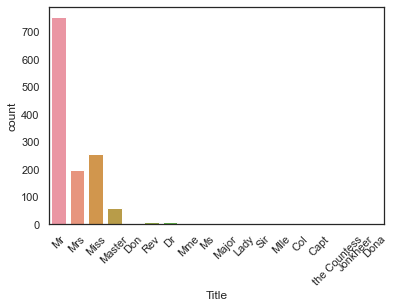

In [37]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.
- 17가지의 호칭들이 있다. 그들중 대부분은 매우 드물고, 우리는 그들을 4가지의 그룹을 지을수 있다

In [38]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

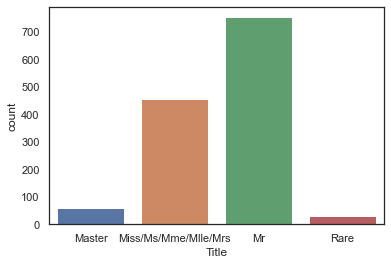

In [39]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

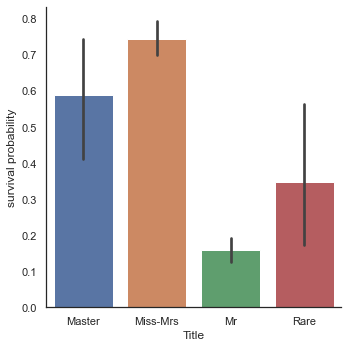

In [40]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"Women and children first"
- '여성과 아이들 먼저'

It is interesting to note that passengers with rare title have more chance to survive.
- 희귀 칭호를 가진 승객이 생존할 확률이 더 높다는 점은 흥미롭다.

In [41]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)
## 이름 변수 삭제

### 5.2 Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).
- 우리는 대가족일수록 대피하는동안 그들의 자매/형제/부모를 찾아 더 대피하기 어려울것이라고 상상할수 있습니다. 그래서 나는 'Fize'(Family Size)라는 피처를 만들기로 정했습니다. SibSp, Parch 그리고 1(승객포함)

In [42]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

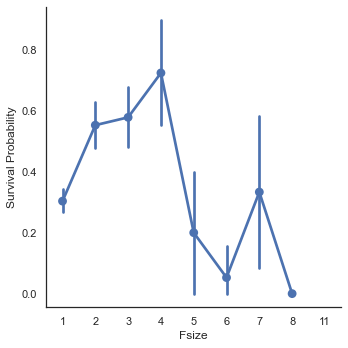

In [43]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

The family size seems to play an important role, survival probability is worst for large families.
- 가족 크기는 중요한 역할을 하는것으로 보이며, 생존확률은 대가족일수록 낮다.

Additionally, i decided to created 4 categories of family size.
- 더해서 나는 가족 크기를 4가지 카테고리로 만들기로 정했다

In [44]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0) #Fize = 1이면 Single
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0) #Fize = 2이면 SmallF
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0) #Fize = 3~4이면 MedF
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0) #Fize => 5이면 LargeF

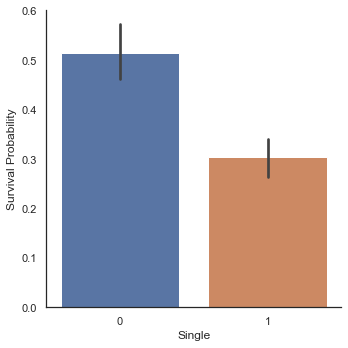

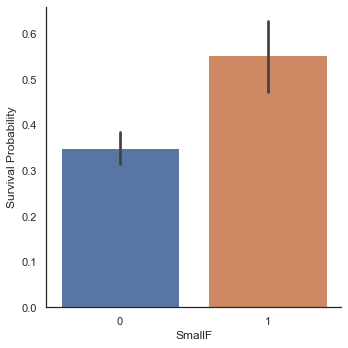

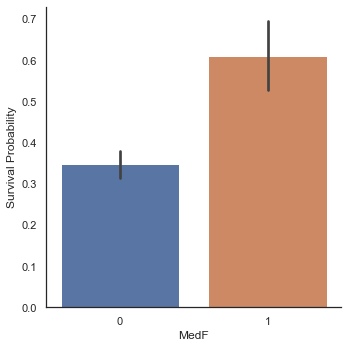

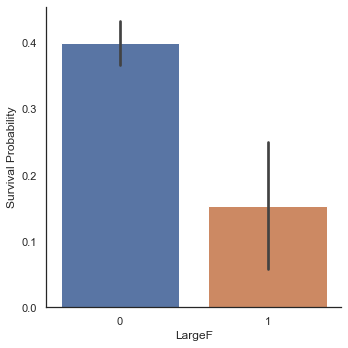

In [45]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.
- 가족크기 카테고리의 Factorplots는 중소 가족이 대가족과 1인가족 보다 더 생존확률이 높았다라는걸 보여준다

In [46]:
# convert to indicator values Title and Embarked 
## One-hot Encoding 사용
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


At this stage, we have 22 features.
- 지금 단계에서는 22개의 피처를 가지고 있다

### 5.3 Cabin

In [48]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.
- 선실 피처 컬럼은 292개의 값과 1007개의 결측치를 가지고 있다.

I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.
- 나는 가정햇다 선실이없는 승객들이 선실번호 대신 결측치를 가지고 있다고

In [51]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])
# 선실코드가 없다면 'X'로 선실코드를 대체한다

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.
- 선실코드의 첫글자는 데스크를 나타낸다. 승객의 가능한위치를 나타내기 때문에 이 정보만 유지하기로 정했다.

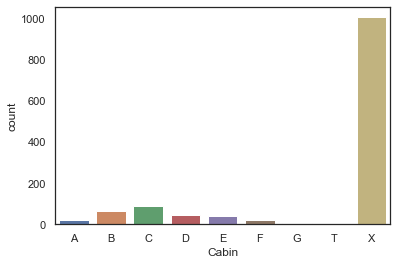

In [53]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

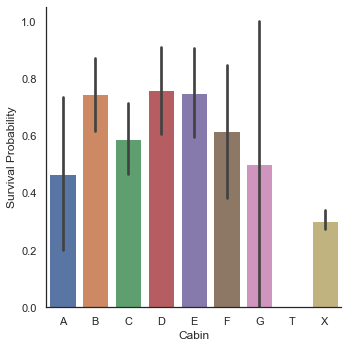

In [54]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.
- 적은 수의 선실 승객때문에, 생존확률은 표준편차 중요하고, 우리는 다른 데스크의 승객의 생존확률 사이를 구별할수 없다

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).
- 그러나 우리는 (X)선실이없는 승객보다 선실의 승객들이 대부분 생존확률이 높았다는것을 볼 수 있다.

It is particularly true for cabin B, C, D, E and F.
- 선실 B, C, D, E, F가 특히 더 그렇습니다.

In [55]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [56]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.
- 동일한 접두사를 공유하는 티켓이 함께 배치된 선실에 대해 예약될 수 있음을 의미 할 수 있다. 따라서 선박 내의 선실의 실제 배치로 이어질 수 있다.

Tickets with same prefixes may have a similar class and survival.
- 접두어가 같은 티켓은 클래스와 생존이 비슷할 수 있다.

So i decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.
- 그래서 티켓의 접두사로 티켓의 피쳐를 바꾸기로 정했습니다. 더 많은 정보를 얻을수 있습니다.

In [57]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [59]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [60]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. MODELING

In [82]:
## Separate train dataset and test dataset
## train, test 데이터셋 나누기

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [83]:
## Separate train features and label 
## train 피쳐 및 이름 나누기

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

### 6.1 Simple modeling

#### 6.1.1 Cross validate models 교차 검증 모델

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.
- 나는 10개의 인기있는 classifiers를 비교했다, 계층화된 kfold 교차 검증 절차를 통해 각 분류기의 평균 정확도를 평가 했다.
  
  
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting ##GBM
- Multiple layer perceptron (neural network) ##MLP
- KNN
- Logistic regression
- Linear Discriminant Analysis ##LDA

In [84]:
# Cross validate model with Kfold stratified cross val
## 교차 검증 모델 , KFold 계층화된 교차
kfold = StratifiedKFold(n_splits=10)

CPU times: user 123 ms, sys: 36.7 ms, total: 159 ms
Wall time: 2.42 s


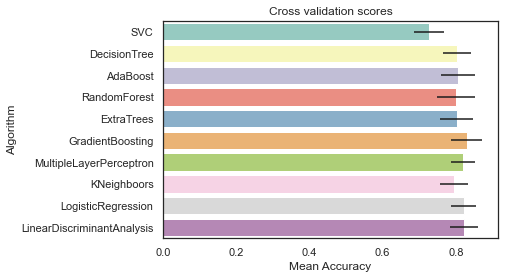

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the defa

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

In [85]:
%%time
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost",
                                    "RandomForest","ExtraTrees","GradientBoosting",
                                    "MultipleLayerPerceptron","KNeighboors","LogisticRegression"
                                    ,"LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

I decided to choose the SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.
- 나는 ensemble모델에서 SVC, AdaBoost, RandomForest, ExtraTrees, GBM 분류기를 사용하기로 했다

#### 6.1.2 Hyperparameter tunning for best models

I performed a grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.
- AdaBoost, ExtraTrees, RandomForest, GradientBoosting 및 SVC 분류기에 대한 그리드 검색 최적화를 수행했습니다.

I set the "n_jobs" parameter to 4 since i have 4 cpu . The computation time is clearly reduced.
- cpu가 4개이므로 "n_jobs" 매개변수를 4로 설정했습니다. 계산 시간이 확실히 줄어듭니다.

But be carefull, this step can take a long time, i took me 15 min in total on 4 cpu.
- 하지만 주의하세요. 이 단계는 시간이 오래 걸릴 수 있습니다. 저는 4개의 CPU에서 총 15분이 걸렸습니다.

In [67]:
%%time
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
CPU times: user 183 ms, sys: 19.8 ms, total: 203 ms
Wall time: 1.48 s


In [68]:
gsadaDTC.best_score_

0.8275536261491316

In [70]:
%%time
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits
CPU times: user 186 ms, sys: 17.6 ms, total: 204 ms
Wall time: 13.6 s


0.8308605720122575

In [71]:
%%time
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits
CPU times: user 258 ms, sys: 29 ms, total: 287 ms
Wall time: 15.2 s


0.8319969356486212

In [72]:
%%time
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the defa

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the defa

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The lo

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The lo

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The lo

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The lo

CPU times: user 303 ms, sys: 25.3 ms, total: 328 ms
Wall time: 9.16 s


0.8308605720122573

In [73]:
%%time
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits
CPU times: user 208 ms, sys: 18.8 ms, total: 227 ms
Wall time: 9.88 s


0.8331332992849847

#### 6.1.3 Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.
- 학습 곡선은 훈련 세트에 대한 과적합 효과와 정확도에 대한 훈련 크기의 영향을 확인하는 좋은 방법입니다.

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The lo

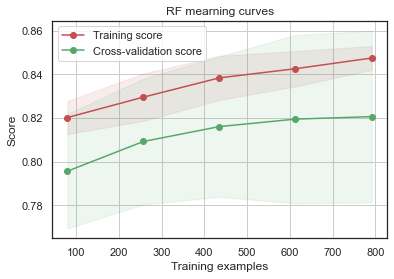

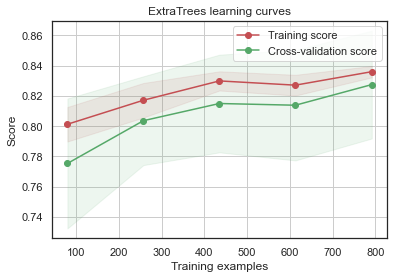

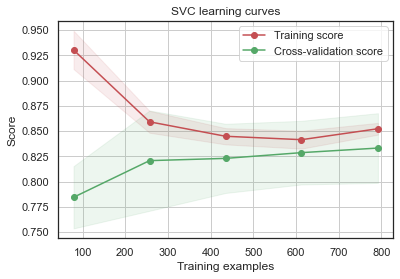

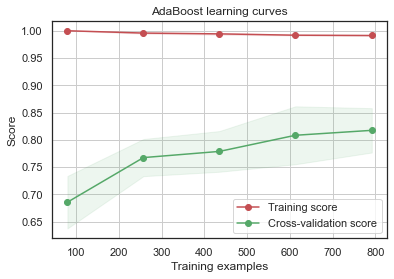

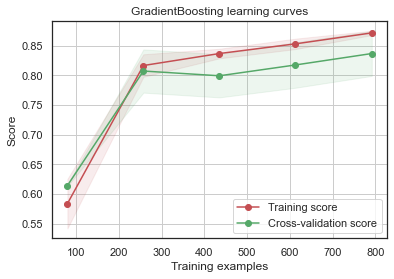

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The lo

/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PY3.8/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The lo

In [75]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.
- GradientBoosting 과 Adaboost classifiers는 훈련데이터를 과대적합하는 경향이 있다. 증가하는 교차검증곡선에 따르면 GradientBoosting 과 Adaboost는 더 많은 훈련 예제를 통해 더 나은 성능을 보일 수 있습니다.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together. 

In [86]:
#### 6.1.4 Feature importance of tree based classifiers

In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.

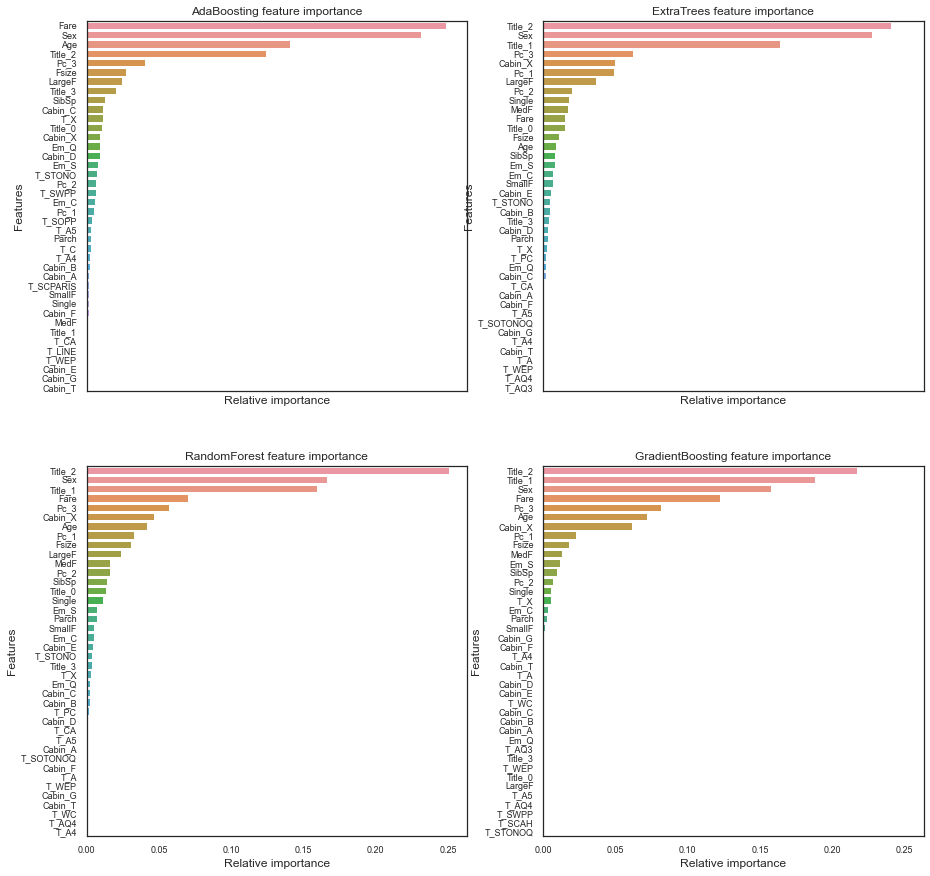

In [87]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1